20.85
20.85
rate: 44100
lenght (s): 20.85


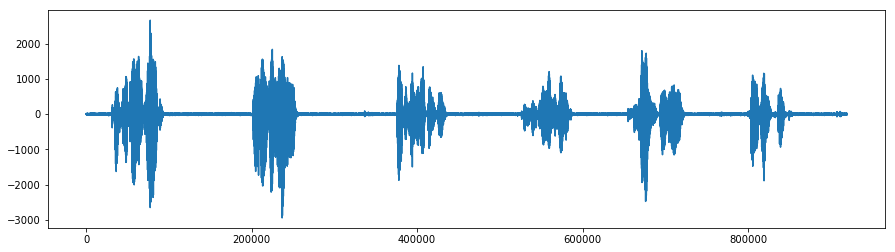

In [1]:
%matplotlib inline
import warnings
## scipy gives a waring when reading wav file
warnings.filterwarnings('ignore')

import scipy as sp
import scipy.io.wavfile
import scipy.signal
import numpy as np
from matplotlib import pyplot as plt

sample_rate, wav_data = scipy.io.wavfile.read("audio-files/kombucha.wav")
# sample_rate, wav_data = sp.io.wavfile.read("anything.wav")
# sample_rate, wav_data = sp.io.wavfile.read("relief.wav")
print(wav_data[:,1].shape[0] / sample_rate)
## taking the mean of the two channels
#mono_data = numpy.mean(wav_data, axis=1)
## taking just one channel
mono_data = wav_data[:, 1]
print(mono_data.shape[0] / sample_rate)
audio_data = mono_data

print("rate:", sample_rate)
print("lenght (s):", len(mono_data) / sample_rate)
plt.figure(figsize=(15, 4))
plt.plot(mono_data)
plt.show()

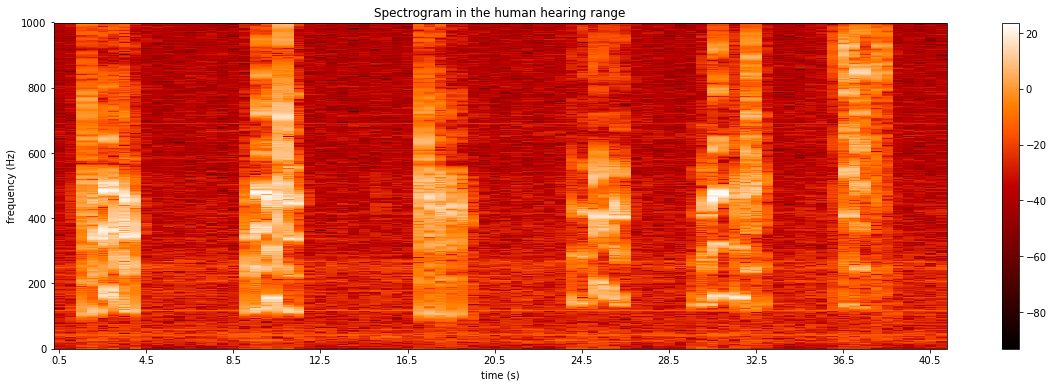

In [34]:
##
# Plotting the spectrogram in the human hearing range
##

segment_length = int(sample_rate/2)
overlap = int(segment_length / 2)
freq_points, t_points, spectrogram = scipy.signal.spectrogram(audio_data, nperseg=segment_length, fs=segment_length,
                                  noverlap=overlap, mode="psd", nfft=sample_rate)
## old overlap int(sample_rate/2)

## just the human hearing range
spectrogram = spectrogram[0:1000, :]

def todB(array):
    mean = np.mean(array)
    return 10 * np.log10(array / mean)


def plotSpectrogram(to_plot, yticks = np.array([]), cmap = plt.cm.gist_heat):
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)
#     plt.imshow(todB(to_plot), cmap=plt.cm.gist_heat)
    plt.imshow(to_plot, cmap=cmap)
    ax.set_aspect('auto')

    ## making pretty
    ax.set_ylim(ax.get_ylim()[::-1]) ## reversing axis
    plt.title("Spectrogram in the human hearing range")
    plt.xlabel("time (s)")
    plt.ylabel("frequency (Hz)")
    num_labels = 10
    xpoints = np.arange(to_plot.shape[1], step=int(to_plot.shape[1]/num_labels))
    plt.xticks(xpoints, t_points[xpoints])
    if (yticks.size > 0):
        plt.yticks(np.arange(to_plot.shape[0]), yticks)
    plt.colorbar(orientation='vertical')
    plt.show()

plotSpectrogram(todB(spectrogram))

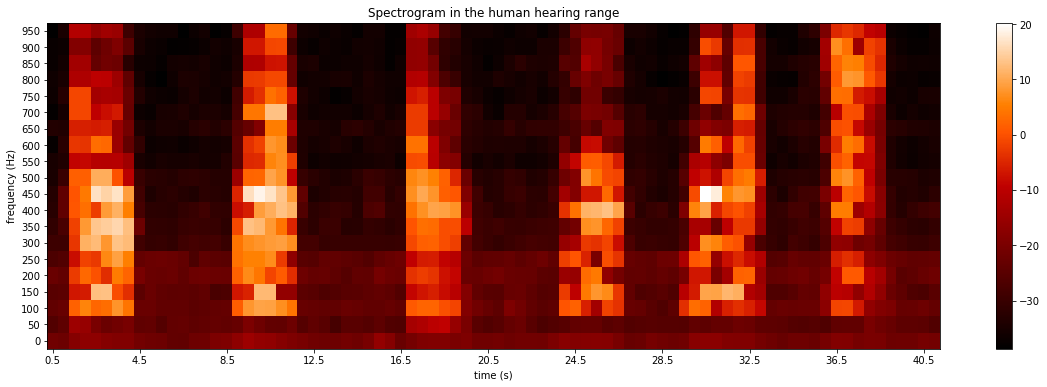

In [35]:
##
# Binning frequencies
##

band_width = 50
num_sections = int(spectrogram.shape[0] / band_width)
test = np.array([[1,2], [4,5], [6,7], [8,9] ])
s = np.transpose(spectrogram)
s_re = np.reshape(s, (spectrogram.shape[1], num_sections, band_width))

## testing
if (all(s[0][0:band_width] == s_re[0][0]) != True):
    raise Exception("something went wrong reshping arrays!")

spectrogram_binned = np.transpose(np.sum(s_re, axis=2))
bands_id_array = np.arange(spectrogram_binned.shape[1])
plt = plotSpectrogram(todB(spectrogram_binned), bands_id_array * band_width)

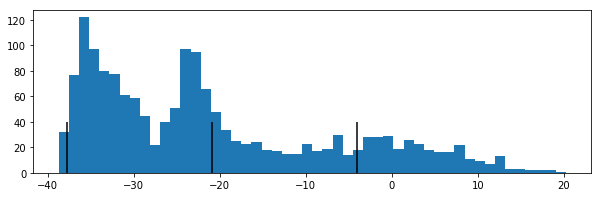

In [36]:
from matplotlib import pyplot as plt

bound_width = 1.2

flat_values = np.ndarray.flatten(spectrogram_binned)
flat_db_values = todB(flat_values)

## some basic stats calculations
mean = np.mean(flat_db_values)
sd = np.std(flat_db_values)
activation_bounds = (mean - bound_width * sd, mean + bound_width * sd)

fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax.hist(flat_db_values, bins=50)
ax.vlines([mean, activation_bounds[0], activation_bounds[1]], 0, 40)
plt.show()

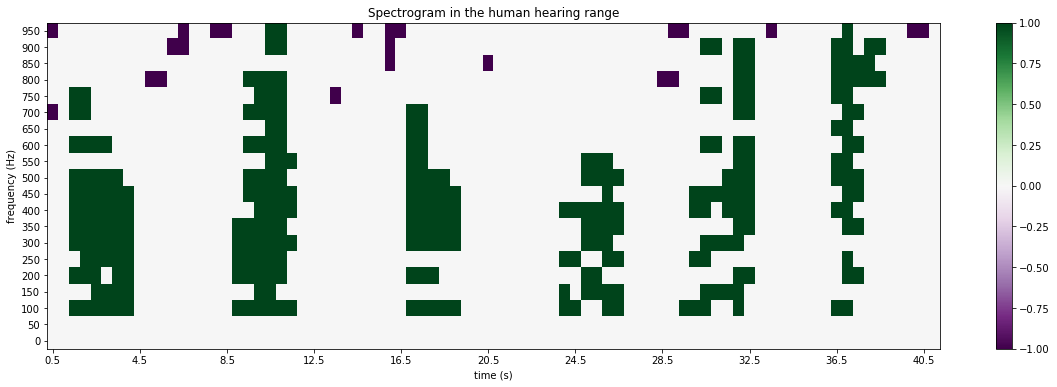

In [37]:
##
# so which spectrogram segments are outside the bounds?
##

sb_db = todB(spectrogram_binned)
spectrogram_outside_activation = np.zeros(spectrogram_binned.shape)
spectrogram_outside_activation[sb_db < activation_bounds[0]] = -1
spectrogram_outside_activation[sb_db > activation_bounds[1]] = 1
# print(spectrogram_outside_activation)
#spectrogram_outside_activation = (spectrogram_binned < activation_bounds[0]) | (spectrogram_binned > activation_bounds[1])

plotSpectrogram(spectrogram_outside_activation, bands_id_array * band_width, cmap=plt.cm.PRGn)

In [6]:
##
# What is the most common pattern of two bands being activated in different time moments?
##
specact = spectrogram_outside_activation
specact = np.abs(specact)

print(specact.shape)
bn = specact.shape[0]
band_corr = np.array([np.correlate(specact[i], specact[k]) for i,k in [(i,j) for i in range(bn) for j in range(bn)]])
band_corr = np.reshape(band_corr, (20,20))
print(band_corr.shape)
print(np.amax(band_corr))
## test
np.correlate(specact[1], specact[19]) == band_corr[1][19]
print(np.argmax(band_corr))
print(band_corr[1][1])
np.fill_diagonal(band_corr, 0)
print("max, not self index", np.argmax(band_corr), "value", np.max(band_corr))
print(band_corr[0][1])

(20, 40)
(20, 20)
20.0
315
0.0
max, not self index 318 value 18.0
0.0
